In [3]:
import torch
import copy
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

%load_ext autoreload
%autoreload 2

In [4]:
data_file = torch.load("data/Crime/data.pt")

In [5]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [5]:
data = data_file['data']
context = data_file['context']
labels = data_file['labels']

In [6]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data, context, labels, test_size=0.1)
data_train, data_val, context_train, context_val, labels_train, labels_val = train_test_split(data_train, context_train, labels_train, test_size=0.1)

In [7]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Split data by label
data_0 = data_train[context_train.flatten()==0]
labels_0 = labels_train[context_train.flatten()==0]
context_0 = context_train[context_train.flatten()==0]

data_1 = data_train[context_train.flatten()==1]
labels_1 = labels_train[context_train.flatten()==1]
context_1 = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

data_0_val = data_val[context_val.flatten()==0]
labels_0_val = labels_val[context_val.flatten()==0]
context_0_val = context_val[context_val.flatten()==0]

data_1_val = data_val[context_val.flatten()==1]
labels_1_val = labels_val[context_val.flatten()==1]
context_1_val = context_val[context_val.flatten()==1]

# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)

label_0_set_val = TensorDataset(data_0_val, labels_0_val, context_0_val)
label_0_generator_val = torch.utils.data.DataLoader(label_0_set_val, **params)

label_1_set_val = TensorDataset(data_1_val, labels_1_val, context_1_val)
label_1_generator_val = torch.utils.data.DataLoader(label_1_set_val, **params)



In [8]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, context_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

data_set_test = TensorDataset(data_test, context_test)
data_generator_test = torch.utils.data.DataLoader(data_set_test, **params)

data_set_val = TensorDataset(data_val, context_val)
data_generator_val = torch.utils.data.DataLoader(data_set_val, **params)

In [9]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1],
                  n_layers = 3,
                  transform_type = 'MaskedAffineAutoregressiveTransform', 
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-3, weight_decay=1e-4)

In [10]:
n_steps_prob = 2000
num_epochs = 5
probability_loss = []
best_params = probability_flow.state_dict()
best_loss_val = np.inf

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, context = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    if (n_step+1) % (n_steps_prob/num_epochs) == 0:
        print(n_step)
        data_val, context_val = next(iter(data_generator_val))
        loss_val = -probability_flow.log_prob(inputs=data_val, context=context_val).mean()
        if loss_val.item() < best_loss_val:
            best_loss_val = loss_val.item()
            best_params = copy.deepcopy(probability_flow.state_dict())
            print(best_loss_val)

    loss.backward()
    optimizer.step()
probability_flow.eval();
probability_flow.load_state_dict(best_params)

 21%|██▏       | 426/2000 [00:01<00:07, 218.29it/s]

399
-4.11843204498291


 41%|████      | 824/2000 [00:03<00:05, 226.60it/s]

799
-4.245622634887695


 62%|██████▏   | 1237/2000 [00:05<00:03, 221.04it/s]

1199
-5.153691291809082


 81%|████████  | 1624/2000 [00:07<00:01, 219.65it/s]

1599


100%|██████████| 2000/2000 [00:09<00:00, 221.32it/s]

1999


<All keys matched successfully>

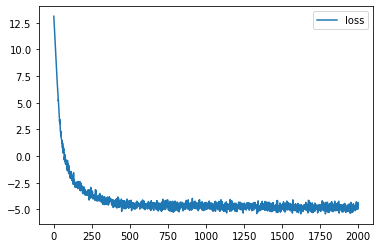

In [ ]:
plt.plot(probability_loss, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


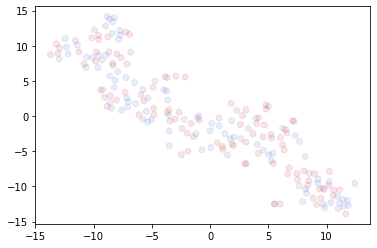

In [ ]:
data, context = next(iter(data_generator_test))
data_embedded = TSNE(n_components=2).fit_transform(data)
samples = probability_flow._sample(num_samples=1, context=context)

catData = torch.cat((data, samples.squeeze(dim=1)))
catData_embedded = TSNE(n_components=2).fit_transform(catData.detach().numpy())
catLabel = torch.cat((torch.zeros(data.shape[0]), torch.ones(samples.shape[0])))

plt.scatter(*catData_embedded.T, c=catLabel, alpha=0.1, cmap='coolwarm')

In [ ]:
gamma = 0.5
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1], 
                  flow_n_layers = 4,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [ ]:
n_steps = 100
num_epochs = 5
best_params_fair = Fair.state_dict()
best_loss_val = np.inf

Fair.train()
for n_step in trange(n_steps):
    data_0, labels_0, context_0 = next(iter(label_0_generator))
    data_1, labels_1, context_1 = next(iter(label_1_generator))
    
    optimizer.zero_grad()

    L_KL, L_clf, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

    total_losses.append(loss.item())
    KL_losses.append(L_KL.item())
    clf_losses.append(L_clf.item())

    if (n_step + 1) % (n_steps / num_epochs) == 0:
        data_0_val, labels_0_val, context_0_val = next(iter(label_0_generator_val))
        data_1_val, labels_1_val, context_1_val = next(iter(label_1_generator_val))
        _, _, loss_val = Fair.loss(data_0_val, data_1_val, labels_0=labels_0_val, labels_1=labels_1_val, context_0=context_0_val, context_1=context_1_val, return_all_losses=True, probability_flow=probability_flow)
        if loss_val.item() < best_loss_val:
            best_loss_val = loss_val.item()
            best_params_fair = copy.deepcopy(Fair.state_dict())
            print(best_loss_val)

    loss.backward()
    optimizer.step()
Fair.eval();
Fair.load_state_dict(best_params_fair)

 20%|██        | 20/100 [00:02<00:14,  5.64it/s]

961.2553100585938


 40%|████      | 40/100 [00:08<00:10,  5.53it/s]

215.0382843017578


 61%|██████    | 61/100 [00:11<00:06,  6.37it/s]

108.18479919433594


 81%|████████  | 81/100 [00:14<00:02,  7.54it/s]

91.85343170166016


 99%|█████████▉| 99/100 [00:17<00:00,  6.47it/s]

64.41808319091797


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


<All keys matched successfully>

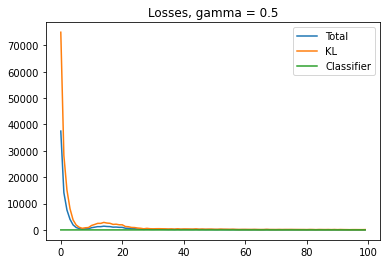

In [ ]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
# plt.ylim(-10,20)
plt.title("Losses, gamma = " + str(gamma))
# plt.savefig("Figures/losses_gamma_" + str(gamma) + ".png")
plt.show()

Text(0.5, 1.0, 'Embedding, gamma = 0.0')

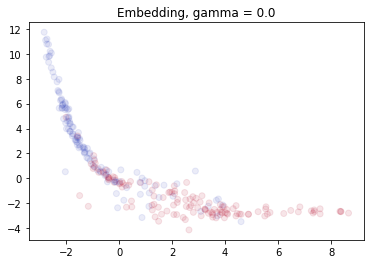

In [ ]:
data_0, labels_0, _ = next(iter(label_0_generator))
data_1, labels_1, _ = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

In [ ]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context'])
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.8350050150451354

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


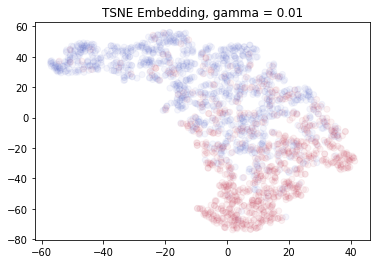

In [ ]:
#Interpreting the representations
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    data_0 = data_file["data"][idx]
    data_1 = data_file["data"][~idx]

    # x0 = probability_flow.sample(num_samples=1, context=data_file["context"][idx]).squeeze()
    # x1 = probability_flow.sample(num_samples=1, context=data_file["context"][~idx]).squeeze()

    embedding_0, embedding_1 = Fair._fair_embed(
        x0=data_0, x1=data_1
    )
    embedding = torch.cat([data_0, embedding_0])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
embed_labels = torch.cat([torch.zeros(data_0.shape[0]), torch.ones(embedding_0.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Embedding, gamma = " + str(gamma))
plt.savefig("Figures/tsne_clustering_gamma_" + str(gamma) + ".png")

For gamma = 1, these two should be on top of one another, but they're not!

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


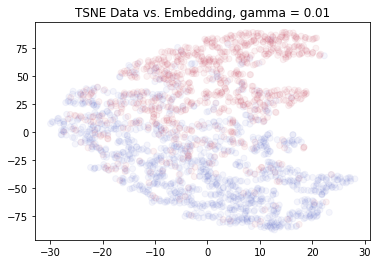

In [ ]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )
    embedding = torch.cat([embedding_0, embedding_1])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
    embed_labels = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Data vs. Embedding, gamma = " + str(gamma))
plt.savefig("Figures/tsne_data_embedding_gamma_" + str(gamma) + ".png")


In [ ]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]

Training set accuracy: 0.586
Test set accuracy: 0.578


tensor(0.0085, grad_fn=<AbsBackward0>)

In [ ]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator))
data_1, labels_1, context_1 = next(iter(label_1_generator))

mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)

In [ ]:
print('gamma:', str(gamma), "mu_star_0_avg:", mu_star_0_avg, "mu_star_1_ave:", mu_star_1_avg, "stat_dist:", stat_dist)

gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)


gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)

gamma: 0.9 mu_star_0_avg: tensor(0.2812) mu_star_1_ave: tensor(0.5938) stat_dist: tensor(-0.3125)

(array([ 3.,  3., 17., 19., 23., 27., 12., 10.,  7.,  7.]),
 array([-6.4149027 , -5.5011477 , -4.5873923 , -3.6736374 , -2.7598822 ,
        -1.846127  , -0.9323719 , -0.01861677,  0.8951384 ,  1.8088934 ,
         2.7226486 ], dtype=float32),
 <BarContainer object of 10 artists>)

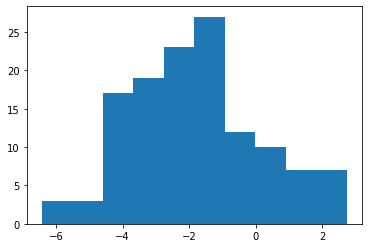

In [ ]:
plt.hist((logP_Z1_z0-logP_Z0_z0).detach().numpy())

In [ ]:
print(f'mu0 = {mu_star_0_avg}, mu1 = {mu_star_1_avg}, stat_dist = {stat_dist}')

mu0 = 0.1875, mu1 = 0.875, stat_dist = -0.6875


In [12]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []

In [13]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                    context_dim=data_file['context'].shape[-1], 
                    flow_n_layers = 4,
                    flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 4,
                    classifier_activation = 'ReLU',
                    gamma=gamma
                    )
    optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)

    n_steps = 1000
    Fair.train()
    for n_step in trange(n_steps):
        data_0, labels_0, context_0 = next(iter(label_0_generator))
        data_1, labels_1, context_1 = next(iter(label_1_generator))
        
        optimizer.zero_grad()

        _, _, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

        loss.backward()
        optimizer.step()
    Fair.eval();

    Fairs.append(Fair)


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([128, 1])) must be the same as input size (torch.Size([128]))

In [ ]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))

Fair.optimal_adversary(data_0_test, data_1_test, context_0_test, context_1_test, probability_flow=probability_flow)
# Fair.gamma

(tensor(-1.),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, F

In [ ]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0_test, data_1_test, context_0=context_0_test, context_1=context_1_test, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[0.8125, 0.3203125, 0.1484375, 0.109375]


In [ ]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx])

acc_test = EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
)

NameError: name 'torch' is not defined

In [ ]:
acc_test

1.0

In [ ]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_file["data"][idx], data_file["data"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Training set accuracy: 0.887
Test set accuracy: 0.849


100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Training set accuracy: 0.639
Test set accuracy: 0.663


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


Training set accuracy: 0.605
Test set accuracy: 0.611


100%|██████████| 100/100 [00:05<00:00, 17.17it/s]

Training set accuracy: 0.603
Test set accuracy: 0.574


In [ ]:
Fairs[0].gamma

0.001

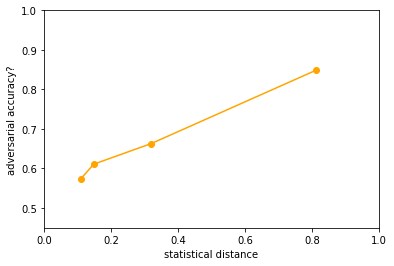

In [ ]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()

add validation set (both to probability flow and FAIR)
85, 10, 5

Check classifier accuracy (separate generation from analysis)
torch.save model
torch.load model
rewrite splitting
save probability flow separately